In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc

## Variables

In [2]:
# reagent 1 name
name_sol1 = "PEG"
# reagent 1 starting contentration
initial_conc_sol1 = 35
# unit
unit_sol1 = "%"


# reagent 2 name
name_sol2 = "Ammonium sulfate"
# reagent 2 starting concentration
initial_conc_sol2 = 8.8
# unit
unit_sol2 = "mM"


# mixing ratio
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 5


# How many hours did the experiment last?
hours_of_experiment = 3.5


# How many pictures where taken per hour per well?
images_per_hour = 2


# percental difference of img mean to all previous imgages. 
percental_threshold = 30 


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
minRadiusChamber = 100
maxRadiusChamber = 150


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
image_folder = "C:/Users/DigitalStation/Documents/Python_Scripts/DropletDetection/TestImages"


## Programm

In [3]:
image_list = []
image_names = []
data_well = {}
well = {}
lane = {}
time_resolution = {}

# Load images & convert to grayscale
pypc.images_to_list(image_list, image_names, image_folder)
pypc.images_to_dict(hours_of_experiment, images_per_hour, number_of_diff_conc, image_list, image_names,
                    time_resolution, lane, well, data_well)

# Detect chamber, create & apply mask
pypc.chamber_detection_and_mask_creation(number_of_diff_conc, time_resolution, minRadiusChamber, maxRadiusChamber)

# Detect LLPS
pypc.detect_LLPS(hours_of_experiment, images_per_hour, number_of_diff_conc,
                 time_resolution, percental_threshold)

# Calculate c_crit
starting_concentrations = pypc.ccrit_calculation(initial_conc_sol1, initial_conc_sol2, initial_ratio,
                       hours_of_experiment, images_per_hour, number_of_diff_conc, time_resolution)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.18it/s]


## quality control

In [4]:
print('initial concentrations:')
print(name_sol1,'', name_sol2)
print(starting_concentrations)

# concentration to check
lane_nr = 0

# well to check
well_nr = 0

#print(f"{name_sol1}", f", conc. {lane_nr}: {":.3f".format(time_resolution[0][lane_nr][well_nr]['LLPS conc'][0,0])} {unit_sol1}")
print(f"{name_sol2}", f", conc. {lane_nr}: {time_resolution[0][lane_nr][well_nr]['LLPS conc'][0,1]} {unit_sol2}")



#draw elon masked image with contour tattoos
#dummy = time_resolution[0][lane_nr][well_nr]['masked image']
#dummyContour = cv2.drawContours(dummy, contours, -1, (0,255,0), 3)
#plt.imshow(dummyContour)

initial concentrations:
PEG  Ammonium sulfate
[[30.          1.25714286]
 [23.75        2.82857143]
 [17.5         4.4       ]
 [11.25        5.97142857]
 [ 5.          7.54285714]]
Ammonium sulfate , conc. 0: 2.0554226898619365 mM


## Plot the data

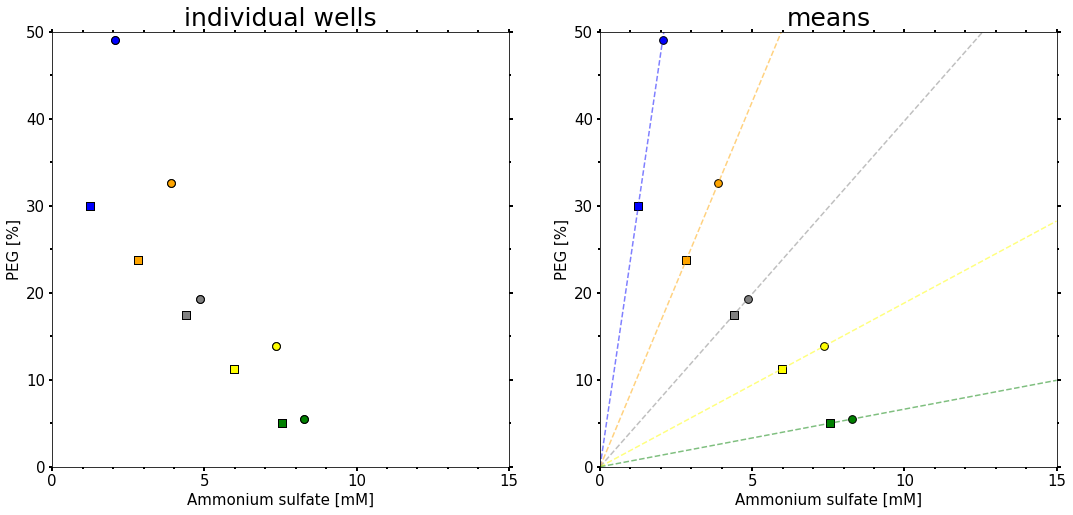

In [7]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol2} [{unit_sol2}]")
ax1.set_ylabel(f"{name_sol1} [{unit_sol1}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = 15
ylim = 50
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(5))
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0
for number_of_columns_per_lane in range(1): # usually 10 on full chip
    for lane_nr in (range(number_of_diff_conc)):
        for number_of_rows_per_lane in range(2):
            if time_resolution[0][lane_nr][well_nr]['well found'] is True and time_resolution[0][lane_nr][well_nr]['LLPS status'] is True:
            
                if lane_nr == 0:
                    color = "blue"
                if lane_nr == 1:
                    color = "orange"
                if lane_nr == 2:
                    color = "gray"
                if lane_nr == 3:
                    color = "yellow"
                if lane_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[lane_nr,1], starting_concentrations[lane_nr,0], s=60, c=color, marker="s", edgecolors="black")

                ax1.scatter(time_resolution[0][lane_nr][well_nr]['LLPS conc'][0,1],time_resolution[0][lane_nr][well_nr]['LLPS conc'][0,0], s=60, color=color,
                           marker="o", edgecolors="black")
                
            well_nr += 1
        well_nr -= 2
    well_nr += 2
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for number_of_columns_per_lane in range(1): # usually 10 on full chip
    for lane_nr in (range(number_of_diff_conc)):
        for number_of_rows_per_lane in range(2):
            if time_resolution[0][lane_nr][well_nr]['well found'] is True and time_resolution[0][lane_nr][well_nr]['LLPS status'] is True:           
                # calculate mean
                mean_sol1[lane_nr] = mean_sol1[lane_nr] + time_resolution[0][lane_nr][well_nr]['LLPS conc'][0,0]
                mean_sol2[lane_nr] = mean_sol2[lane_nr] + time_resolution[0][lane_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[lane_nr] += 1  
                
            well_nr += 1
        well_nr -= 2
    well_nr += 2
well_nr = 0


for lane_nr in range(5):
    if lane_nr == 0:
        color = "blue"
    if lane_nr == 1:
        color = "orange"
    if lane_nr == 2:
        color = "gray"
    if lane_nr == 3:
        color = "yellow"
    if lane_nr == 4:
        color = "green"
    mean_sol1[lane_nr] = mean_sol1[lane_nr]/n_llps_wells[lane_nr]
    mean_sol2[lane_nr] = mean_sol2[lane_nr]/n_llps_wells[lane_nr]
    
    m = mean_sol1[lane_nr]/mean_sol2[lane_nr]
    ax2.plot([0, mean_sol2[lane_nr],xlim], [0, mean_sol1[lane_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[lane_nr,1], starting_concentrations[lane_nr,0], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol2[lane_nr],mean_sol1[lane_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 